In [1]:
# ============================================================================
# MOD002691 - FINAL PROJECT: SNAPSHELF DATASET PREPARATION
# ============================================================================
#
# Author:       Oriol Morros Vilaseca (SID: 2270056)
# Supervisor:   Mr Vitaliy Milke
# Institution:  Anglia Ruskin University, Cambridge
# Module:       MOD002691 - Final Project (BSc Software Engineering)
# Date:         January 2026
#
# ============================================================================
# PURPOSE
# ============================================================================
#
# This notebook prepares a unified dataset for comparing three CNN architectures:
#   1. Custom CNN (baseline, trained from scratch)
#   2. EfficientNetB0 (transfer learning)
#   3. ResNet-50 (transfer learning)
#
# ============================================================================
# METHODOLOGY
# ============================================================================
#
# Data Sources:
#   - Kaggle: moltean/fruits (Fruits-360)
#   - Kaggle: sshikamaru/fruit-recognition
#   - Kaggle: utkarshsaxenadn/fruits-classification
#
# Processing Pipeline:
#   1. Extract and merge source datasets
#   2. Map folder names to 14 target classes using include/exclude patterns
#   3. Remove exact duplicates via SHA-256 hashing (global, before split)
#   4. Stratified 70/15/15 train/val/test split
#   5. Verify zero data leakage across splits
#   6. Compute class weights to handle imbalance
#
# ============================================================================
# OUTPUT FILES
# ============================================================================
#
#   snapshelf_dataset_14classes_deduped.zip  - Final dataset archive
#   dataset_manifest.csv                     - Full provenance with SHA-256
#   deduplication_report.csv                 - Removed duplicates log
#   exclusion_audit.csv                      - Filtered folders log
#   class_mapping_verification.csv           - QA audit sample
#   class_weights.csv                        - Training weights for imbalance
#   dataset_statistics.png                   - Distribution visualisation
#
# ============================================================================

In [2]:
# ============================================================================
# CELL 1: ENVIRONMENT SETUP
# ============================================================================
# Displays runtime environment information for reproducibility documentation.
# ============================================================================

import sys
import platform
from datetime import datetime

print("=" * 70)
print("SNAPSHELF - DATASET PREPARATION")
print("=" * 70)
print(f"Execution:  {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Python:     {sys.version.split()[0]}")
print(f"Platform:   {platform.platform()}")
print("=" * 70)

SNAPSHELF - DATASET PREPARATION
Execution:  2026-01-24 17:17:06
Python:     3.12.12
Platform:   Linux-6.6.105+-x86_64-with-glibc2.35


In [3]:
# ============================================================================
# CELL 2: IMPORTS AND DEPENDENCIES
# ============================================================================
# Core libraries for file handling, hashing, and data processing.
# Random seed fixed at 42 for reproducibility across all operations.
# ============================================================================

from google.colab import drive
import os
import shutil
import random
import hashlib
import zipfile
import numpy as np
from pathlib import Path
from collections import defaultdict
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

drive.mount('/content/drive')

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

try:
    from sklearn.utils.class_weight import compute_class_weight
    print("scikit-learn loaded")
except ImportError:
    !pip install scikit-learn -q
    from sklearn.utils.class_weight import compute_class_weight
    print("scikit-learn installed")

print(f"Random seed: {SEED}")

Mounted at /content/drive
scikit-learn loaded
Random seed: 42


In [4]:
# ============================================================================
# CELL 3: CONFIGURATION
# ============================================================================
# Defines source paths, output paths, and target class mappings.
#
# Class Mapping Strategy:
#   Each class has 'include' patterns (must match) and 'exclude' patterns
#   (must not match). This prevents semantic contamination where substring
#   matching would incorrectly assign images:
#     - 'grape' would match 'grapefruit' without exclusion
#     - 'orange' would match 'pepper orange' without exclusion
# ============================================================================

DRIVE_BASE = "/content/drive/MyDrive/smartfoodai_datasets"
SOURCE_DATASETS = {
    "fruits_360": f"{DRIVE_BASE}/archive (3).zip",
    "fruit_recognition": f"{DRIVE_BASE}/archive (1).zip",
    "fruits_classification": f"{DRIVE_BASE}/archive (2).zip"
}

OUTPUT_BASE = "/content/drive/MyDrive/snapshelf_final_dataset"
EXTRACTION_DIR = "/content/datasets_raw"

MANIFEST_PATH = f"{OUTPUT_BASE}/dataset_manifest.csv"
DEDUP_REPORT_PATH = f"{OUTPUT_BASE}/deduplication_report.csv"
CLASS_MAPPING_PATH = f"{OUTPUT_BASE}/class_mapping_verification.csv"
SOURCE_DISTRIBUTION_PATH = f"{OUTPUT_BASE}/source_distribution.csv"
CLASS_WEIGHTS_PATH = f"{OUTPUT_BASE}/class_weights.csv"
STATISTICS_PLOT_PATH = f"{OUTPUT_BASE}/dataset_statistics.png"
HASH_CACHE_PATH = f"{OUTPUT_BASE}/hash_cache.csv"
EXCLUSION_AUDIT_PATH = f"{OUTPUT_BASE}/exclusion_audit.csv"

# 14 target classes with include/exclude patterns
TARGET_CLASSES = {
    "apple": {
        "include": ["apple"],
        "exclude": ["pineapple", "custard apple", "sugar apple"]
    },
    "banana": {
        "include": ["banana"],
        "exclude": []
    },
    "orange": {
        "include": ["orange"],
        "exclude": ["pepper orange", "tomato orange", "tomato cherry orange", "cherry orange"]
    },
    "lemon": {
        "include": ["lemon"],
        "exclude": []
    },
    "strawberry": {
        "include": ["strawberry"],
        "exclude": []
    },
    "grape": {
        "include": ["grape"],
        "exclude": ["grapefruit", "grape fruit"]
    },
    "peach": {
        "include": ["peach"],
        "exclude": []
    },
    "tomato": {
        "include": ["tomato"],
        "exclude": []
    },
    "potato": {
        "include": ["potato"],
        "exclude": []
    },
    "onion": {
        "include": ["onion"],
        "exclude": []
    },
    "carrot": {
        "include": ["carrot"],
        "exclude": []
    },
    "bell_pepper_red": {
        "include": ["pepper red"],
        "exclude": []
    },
    "bell_pepper_green": {
        "include": ["pepper green"],
        "exclude": []
    },
    "cucumber": {
        "include": ["cucumber"],
        "exclude": []
    }
}

TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

VALID_EXTENSIONS = {".jpg", ".jpeg", ".png"}
DEDUP_EXACT_SHA256 = True

# Verify configuration
print("=" * 70)
print("CONFIGURATION")
print("=" * 70)

print(f"\n[Source Datasets]")
for name, path in SOURCE_DATASETS.items():
    status = "FOUND" if os.path.exists(path) else "NOT FOUND"
    print(f"  {name}: {status}")

print(f"\n[Output Directory]")
print(f"  {OUTPUT_BASE}")

print(f"\n[Parameters]")
print(f"  Classes: {len(TARGET_CLASSES)}")
print(f"  Split:   {TRAIN_RATIO:.0%} / {VAL_RATIO:.0%} / {TEST_RATIO:.0%}")
print(f"  Dedup:   SHA-256 enabled")

print(f"\n[Exclusion Patterns]")
for cls, cfg in TARGET_CLASSES.items():
    if cfg["exclude"]:
        print(f"  {cls}: {cfg['exclude']}")

assert abs(TRAIN_RATIO + VAL_RATIO + TEST_RATIO - 1.0) < 0.001
print("\nConfiguration validated")

CONFIGURATION

[Source Datasets]
  fruits_360: FOUND
  fruit_recognition: FOUND
  fruits_classification: FOUND

[Output Directory]
  /content/drive/MyDrive/snapshelf_final_dataset

[Parameters]
  Classes: 14
  Split:   70% / 15% / 15%
  Dedup:   SHA-256 enabled

[Exclusion Patterns]
  apple: ['pineapple', 'custard apple', 'sugar apple']
  orange: ['pepper orange', 'tomato orange', 'tomato cherry orange', 'cherry orange']
  grape: ['grapefruit', 'grape fruit']

Configuration validated


In [5]:
# ============================================================================
# CELL 4: EXTRACT SOURCE DATASETS
# ============================================================================
# Extracts each Kaggle archive into a named subfolder to maintain provenance.
# ============================================================================

def extract_dataset(zip_path, base_dir, name):
    """Extract zip archive to named subfolder."""
    target = os.path.join(base_dir, name)
    try:
        os.makedirs(target, exist_ok=True)
        with zipfile.ZipFile(zip_path, 'r') as z:
            z.extractall(target)
        count = sum(len(f) for _, _, f in os.walk(target))
        print(f"  [OK] {name}: {count:,} files")
        return True
    except Exception as e:
        print(f"  [ERROR] {name}: {e}")
        return False

print("=" * 70)
print("EXTRACTING DATASETS")
print("=" * 70)

if os.path.exists(EXTRACTION_DIR):
    shutil.rmtree(EXTRACTION_DIR)
os.makedirs(EXTRACTION_DIR)

print()
for name, path in SOURCE_DATASETS.items():
    extract_dataset(path, EXTRACTION_DIR, name)

print("\nExtraction complete")

EXTRACTING DATASETS

  [OK] fruits_360: 283,619 files
  [OK] fruit_recognition: 22,496 files
  [OK] fruits_classification: 10,001 files

Extraction complete


In [6]:
# ============================================================================
# CELL 5: SCAN AND MAP IMAGES
# ============================================================================
# Scans extracted directories and assigns images to classes based on
# folder names. Uses include/exclude pattern matching to prevent
# misclassification from substring collisions.
# ============================================================================

def get_source(path, base):
    """Extract source dataset name from file path."""
    return os.path.relpath(path, base).split(os.sep)[0]


def matches_class(folder, class_config):
    """Check if folder matches class include patterns but not exclude patterns."""
    name = folder.lower().replace("_", " ").replace("-", " ")

    include_match = any(kw in name for kw in class_config["include"])
    if not include_match:
        return False

    exclude_match = any(kw in name for kw in class_config["exclude"])
    if exclude_match:
        return False

    return True


def scan_images(base_path, classes, extensions):
    """Scan directories and collect images with class assignments."""
    images = []
    exclusion_audit = []
    processed_folders = set()

    for root, _, files in os.walk(base_path):
        folder = os.path.basename(root)
        source = get_source(root, base_path)
        folder_key = (source, folder)

        matched_class = None
        for cls, config in classes.items():
            if matches_class(folder, config):
                matched_class = cls
                break

        # Track exclusions for audit
        if folder_key not in processed_folders:
            processed_folders.add(folder_key)
            folder_lower = folder.lower().replace("_", " ").replace("-", " ")

            for cls, config in classes.items():
                if any(kw in folder_lower for kw in config["include"]):
                    matching_excludes = [kw for kw in config["exclude"] if kw in folder_lower]
                    if matching_excludes:
                        exclusion_audit.append({
                            'folder_name': folder,
                            'source_dataset': source,
                            'would_match_class': cls,
                            'excluded_by_pattern': ', '.join(matching_excludes),
                            'folder_path': root
                        })

        if matched_class:
            for f in files:
                if os.path.splitext(f)[1].lower() in extensions:
                    images.append({
                        'path': os.path.join(root, f),
                        'source_dataset': source,
                        'folder_name': folder,
                        'original_filename': f,
                        'class_name': matched_class
                    })

    return images, exclusion_audit


print("=" * 70)
print("SCANNING IMAGES")
print("=" * 70)

all_images_raw, exclusion_audit = scan_images(EXTRACTION_DIR, TARGET_CLASSES, VALID_EXTENSIONS)

class_counts = defaultdict(int)
for img in all_images_raw:
    class_counts[img['class_name']] += 1

print(f"\n{'Class':<20} {'Count':>10}")
print("-" * 32)
for cls in sorted(TARGET_CLASSES.keys()):
    print(f"{cls:<20} {class_counts[cls]:>10,}")
print("-" * 32)
print(f"{'TOTAL':<20} {len(all_images_raw):>10,}")

source_counts = defaultdict(int)
for img in all_images_raw:
    source_counts[img['source_dataset']] += 1

print(f"\n[By Source]")
for src in sorted(source_counts.keys()):
    print(f"  {src}: {source_counts[src]:,}")

if exclusion_audit:
    print(f"\n[Excluded Folders] {len(exclusion_audit)} folder(s) filtered:")
    for exc in exclusion_audit:
        print(f"  [EXCLUDED] {exc['folder_name']:<25} (matched '{exc['would_match_class']}', blocked by: '{exc['excluded_by_pattern']}')")

    os.makedirs(OUTPUT_BASE, exist_ok=True)
    pd.DataFrame(exclusion_audit).to_csv(EXCLUSION_AUDIT_PATH, index=False)
    print(f"\n  Audit saved: {EXCLUSION_AUDIT_PATH}")

print(f"\nTotal: {len(all_images_raw):,} images across {len(TARGET_CLASSES)} classes")

SCANNING IMAGES

Class                     Count
--------------------------------
apple                    67,587
banana                    5,699
bell_pepper_green         1,036
bell_pepper_red           1,554
carrot                      402
cucumber                 15,773
grape                     7,549
lemon                     1,804
onion                     7,000
orange                    1,118
peach                    10,996
potato                    2,854
strawberry                4,132
tomato                   35,812
--------------------------------
TOTAL                   163,316

[By Source]
  fruit_recognition: 7,541
  fruits_360: 147,775
  fruits_classification: 8,000

[Excluded Folders] 7 folder(s) filtered:
  [EXCLUDED] Pineapple                 (matched 'apple', blocked by: 'pineapple')
  [EXCLUDED] Tomato Cherry Orange 1    (matched 'orange', blocked by: 'tomato cherry orange, cherry orange')
  [EXCLUDED] Grapefruit White 1        (matched 'grape', blocked by: 'grapefrui

In [7]:
# ============================================================================
# CELL 6: CLASS MAPPING VERIFICATION
# ============================================================================
# Generates a random sample of 50 images per class for manual QA review.
# The audit_label column can be filled with Y/N to document accuracy.
# ============================================================================

print("=" * 70)
print("CLASS MAPPING VERIFICATION")
print("=" * 70)

SAMPLES_PER_CLASS = 50
images_by_class = defaultdict(list)
for img in all_images_raw:
    images_by_class[img['class_name']].append(img)

verification_records = []
for cls in sorted(TARGET_CLASSES.keys()):
    samples = random.sample(images_by_class[cls], min(SAMPLES_PER_CLASS, len(images_by_class[cls])))
    for img in samples:
        verification_records.append({
            'matched_class': cls,
            'folder_name': img['folder_name'],
            'source_dataset': img['source_dataset'],
            'original_filename': img['original_filename'],
            'full_path': img['path'],
            'audit_label': ''
        })

verification_df = pd.DataFrame(verification_records)
os.makedirs(os.path.dirname(CLASS_MAPPING_PATH), exist_ok=True)
verification_df.to_csv(CLASS_MAPPING_PATH, index=False)

print(f"\nSamples exported: {len(verification_df)}")
print(f"Output: {CLASS_MAPPING_PATH}")
print(f"\nInstructions:")
print(f"  1. Review sample images manually")
print(f"  2. Mark audit_label as Y (correct) or N (incorrect)")
print(f"  3. Calculate and report accuracy in dissertation")

CLASS MAPPING VERIFICATION

Samples exported: 700
Output: /content/drive/MyDrive/snapshelf_final_dataset/class_mapping_verification.csv

Instructions:
  1. Review sample images manually
  2. Mark audit_label as Y (correct) or N (incorrect)
  3. Calculate and report accuracy in dissertation


In [8]:
# ============================================================================
# CELL 7: SHA-256 DEDUPLICATION
# ============================================================================
# Removes exact duplicate images using cryptographic hashing.
# Deduplication is performed globally BEFORE splitting to prevent
# the same image appearing in multiple splits (data leakage).
# ============================================================================

def compute_sha256(path):
    """Compute SHA-256 hash of file contents."""
    try:
        h = hashlib.sha256()
        with open(path, "rb") as f:
            for chunk in iter(lambda: f.read(8192), b""):
                h.update(chunk)
        return h.hexdigest()
    except:
        return None


def validate_image(path):
    """Verify file is a valid, readable image."""
    try:
        with Image.open(path) as img:
            img.verify()
        with Image.open(path) as img:
            img.convert("RGB")
        return True
    except:
        return False


def deduplicate_sha256(images):
    """Remove exact duplicates, keeping first occurrence."""
    hashed = []
    corrupt = []

    for img in tqdm(images, desc="Hashing"):
        if not validate_image(img['path']):
            corrupt.append(img)
            continue
        sha = compute_sha256(img['path'])
        if sha:
            hashed.append({**img, 'sha256': sha})
        else:
            corrupt.append(img)

    if corrupt:
        print(f"\n  [WARNING] Skipped {len(corrupt)} corrupt images")

    groups = defaultdict(list)
    for img in hashed:
        groups[img['sha256']].append(img)

    kept = []
    removed = []
    for sha, group in groups.items():
        kept.append(group[0])
        for dup in group[1:]:
            removed.append({
                'removed_path': dup['path'],
                'removed_source': dup['source_dataset'],
                'removed_class': dup['class_name'],
                'sha256': sha,
                'duplicate_of': group[0]['path'],
                'kept_source': group[0]['source_dataset'],
                'reason': 'exact_sha256'
            })

    return kept, removed, corrupt


print("=" * 70)
print("DEDUPLICATION (SHA-256)")
print("=" * 70)

print(f"\nMethod: SHA-256 cryptographic hash")
print(f"Scope:  Global (before split)")
print(f"Input:  {len(all_images_raw):,} images\n")

kept_images, removed_report, corrupt_images = deduplicate_sha256(all_images_raw)

removed_count = len(removed_report)
pct = (removed_count / len(all_images_raw) * 100) if all_images_raw else 0

print(f"\n[Results]")
print(f"  Original:   {len(all_images_raw):,}")
print(f"  Corrupt:    {len(corrupt_images):,}")
print(f"  Duplicates: {removed_count:,} ({pct:.1f}%)")
print(f"  Final:      {len(kept_images):,}")

cross_src = sum(1 for r in removed_report if r['removed_source'] != r['kept_source'])
if cross_src:
    print(f"\n  Cross-source duplicates: {cross_src:,}")

if removed_report:
    pd.DataFrame(removed_report).to_csv(DEDUP_REPORT_PATH, index=False)
    print(f"\nReport saved: {DEDUP_REPORT_PATH}")

all_images_deduped = kept_images

DEDUPLICATION (SHA-256)

Method: SHA-256 cryptographic hash
Scope:  Global (before split)
Input:  163,316 images



Hashing: 100%|██████████| 163316/163316 [01:49<00:00, 1488.95it/s]



[Results]
  Original:   163,316
  Corrupt:    0
  Duplicates: 42,474 (26.0%)
  Final:      120,842

  Cross-source duplicates: 9,263

Report saved: /content/drive/MyDrive/snapshelf_final_dataset/deduplication_report.csv


In [9]:
# ============================================================================
# CELL 8: STRATIFIED SPLIT
# ============================================================================
# Splits data into train/val/test while preserving class proportions.
# Each class is independently shuffled and split at the specified ratios.
# ============================================================================

def stratified_split(images, train_r, val_r, test_r, seed=42):
    """Create stratified train/val/test split preserving class proportions."""
    random.seed(seed)
    by_class = defaultdict(list)
    for img in images:
        by_class[img['class_name']].append(img)

    train, val, test = [], [], []
    for cls, imgs in by_class.items():
        random.shuffle(imgs)
        n = len(imgs)
        t_end = int(n * train_r)
        v_end = t_end + int(n * val_r)
        train.extend(imgs[:t_end])
        val.extend(imgs[t_end:v_end])
        test.extend(imgs[v_end:])

    return train, val, test


print("=" * 70)
print("STRATIFIED SPLIT")
print("=" * 70)

print(f"\nInput: {len(all_images_deduped):,} images")
print(f"Ratio: {TRAIN_RATIO:.0%} / {VAL_RATIO:.0%} / {TEST_RATIO:.0%}")
print(f"Seed:  {SEED}")

train_images, val_images, test_images = stratified_split(
    all_images_deduped, TRAIN_RATIO, VAL_RATIO, TEST_RATIO, SEED
)

def count_classes(images):
    c = defaultdict(int)
    for img in images:
        c[img['class_name']] += 1
    return c

train_c = count_classes(train_images)
val_c = count_classes(val_images)
test_c = count_classes(test_images)

print(f"\n{'Class':<20} {'Train':>8} {'Val':>8} {'Test':>8}")
print("-" * 48)
for cls in sorted(TARGET_CLASSES.keys()):
    print(f"{cls:<20} {train_c[cls]:>8,} {val_c[cls]:>8,} {test_c[cls]:>8,}")
print("-" * 48)
print(f"{'TOTAL':<20} {len(train_images):>8,} {len(val_images):>8,} {len(test_images):>8,}")

total = len(train_images) + len(val_images) + len(test_images)
print(f"\n  Train: {len(train_images)/total:.1%}")
print(f"  Val:   {len(val_images)/total:.1%}")
print(f"  Test:  {len(test_images)/total:.1%}")

STRATIFIED SPLIT

Input: 120,842 images
Ratio: 70% / 15% / 15%
Seed:  42

Class                   Train      Val     Test
------------------------------------------------
apple                  31,818    6,818    6,819
banana                  3,624      776      778
bell_pepper_green         414       88       90
bell_pepper_red           621      133      134
carrot                    281       60       61
cucumber               10,766    2,307    2,308
grape                   4,567      978      980
lemon                     918      196      198
onion                   4,593      984      985
orange                    447       95       97
peach                   7,352    1,575    1,577
potato                  1,682      360      362
strawberry              2,518      539      541
tomato                 14,981    3,210    3,211
------------------------------------------------
TOTAL                  84,582   18,119   18,141

  Train: 70.0%
  Val:   15.0%
  Test:  15.0%


In [10]:
# ============================================================================
# CELL 9: LEAKAGE VERIFICATION
# ============================================================================
# Verifies no images appear in multiple splits by checking SHA-256
# hash intersections. Any overlap would indicate data leakage.
# ============================================================================

def verify_leakage(train, val, test):
    """Check for SHA-256 hash collisions across splits."""
    train_h = set(img['sha256'] for img in train)
    val_h = set(img['sha256'] for img in val)
    test_h = set(img['sha256'] for img in test)

    return {
        'train_val': len(train_h & val_h),
        'train_test': len(train_h & test_h),
        'val_test': len(val_h & test_h),
        'clean': len(train_h & val_h) + len(train_h & test_h) + len(val_h & test_h) == 0
    }


print("=" * 70)
print("LEAKAGE VERIFICATION")
print("=" * 70)

print(f"\nMethod: SHA-256 hash intersection")

leak = verify_leakage(train_images, val_images, test_images)

print(f"\n[Cross-Split Overlaps]")
print(f"  Train AND Val:  {leak['train_val']}")
print(f"  Train AND Test: {leak['train_test']}")
print(f"  Val AND Test:   {leak['val_test']}")

if leak['clean']:
    print(f"\nRESULT: PASSED - No data leakage detected")
    LEAKAGE_CHECK_PASSED = True
else:
    print(f"\nRESULT: FAILED - Overlapping images found")
    LEAKAGE_CHECK_PASSED = False

LEAKAGE VERIFICATION

Method: SHA-256 hash intersection

[Cross-Split Overlaps]
  Train AND Val:  0
  Train AND Test: 0
  Val AND Test:   0

RESULT: PASSED - No data leakage detected


In [11]:
# ============================================================================
# CELL 10: COPY IMAGES AND BUILD MANIFEST
# ============================================================================
# Copies images to structured output directory (split/class/filename)
# and generates a manifest CSV with full provenance for each image.
# ============================================================================

def copy_with_manifest(images, output_dir, split_name):
    """Copy images to output directory and generate manifest records."""
    records = []
    by_class = defaultdict(list)
    for img in images:
        by_class[img['class_name']].append(img)

    copied = 0
    for cls, imgs in by_class.items():
        cls_dir = os.path.join(output_dir, cls)
        os.makedirs(cls_dir, exist_ok=True)

        for idx, img in enumerate(imgs):
            ext = os.path.splitext(img['path'])[1].lower()
            new_name = f"{cls}_{idx:05d}{ext}"
            dst = os.path.join(cls_dir, new_name)

            try:
                shutil.copy2(img['path'], dst)
                copied += 1
                records.append({
                    'split': split_name,
                    'class': cls,
                    'new_filename': new_name,
                    'orig_path': img['path'],
                    'source_dataset': img['source_dataset'],
                    'original_folder': img['folder_name'],
                    'original_filename': img['original_filename'],
                    'sha256': img.get('sha256', '')
                })
            except Exception as e:
                print(f"  Error copying: {e}")

    return copied, records


LOCAL_OUTPUT = "/content/snapshelf_dataset_local"

print("=" * 70)
print("COPYING IMAGES")
print("=" * 70)

if os.path.exists(LOCAL_OUTPUT):
    shutil.rmtree(LOCAL_OUTPUT)
os.makedirs(LOCAL_OUTPUT)

print()
all_records = []

train_n, train_r = copy_with_manifest(train_images, f"{LOCAL_OUTPUT}/train", "train")
print(f"  Train: {train_n:,}")
all_records.extend(train_r)

val_n, val_r = copy_with_manifest(val_images, f"{LOCAL_OUTPUT}/val", "val")
print(f"  Val:   {val_n:,}")
all_records.extend(val_r)

test_n, test_r = copy_with_manifest(test_images, f"{LOCAL_OUTPUT}/test", "test")
print(f"  Test:  {test_n:,}")
all_records.extend(test_r)

manifest_df = pd.DataFrame(all_records)
manifest_df.to_csv(f"{LOCAL_OUTPUT}/dataset_manifest.csv", index=False)

print(f"\nTotal: {train_n + val_n + test_n:,} images")
print(f"Manifest: {len(manifest_df)} records")

COPYING IMAGES

  Train: 84,582
  Val:   18,119
  Test:  18,141

Total: 120,842 images
Manifest: 120842 records


In [12]:
# ============================================================================
# CELL 11: CLASS WEIGHTS
# ============================================================================
# Computes balanced class weights to handle class imbalance during training.
# Weights are inversely proportional to class frequency.
# ============================================================================

print("=" * 70)
print("CLASS WEIGHTS")
print("=" * 70)

classes = sorted(TARGET_CLASSES.keys())
counts = [train_c[c] for c in classes]
labels = [img['class_name'] for img in train_images]

weights = compute_class_weight('balanced', classes=np.array(classes), y=np.array(labels))

print(f"\n{'Class':<20} {'Count':>8} {'Weight':>10}")
print("-" * 40)
for cls, cnt, w in zip(classes, counts, weights):
    print(f"{cls:<20} {cnt:>8,} {w:>10.4f}")

max_w = max(zip(classes, weights), key=lambda x: x[1])
min_w = min(zip(classes, weights), key=lambda x: x[1])
print(f"\nImbalance ratio: {max_w[1]/min_w[1]:.1f}x ({max_w[0]} vs {min_w[0]})")

weights_df = pd.DataFrame({'class': classes, 'count': counts, 'weight': weights})
weights_df.to_csv(CLASS_WEIGHTS_PATH, index=False)
print(f"\nSaved: {CLASS_WEIGHTS_PATH}")

print(f"\n[Usage]")
print(f"  Keras:   model.fit(..., class_weight=weight_dict)")
print(f"  PyTorch: nn.CrossEntropyLoss(weight=tensor)")

CLASS WEIGHTS

Class                   Count     Weight
----------------------------------------
apple                  31,818     0.1899
banana                  3,624     1.6671
bell_pepper_green         414    14.5932
bell_pepper_red           621     9.7288
carrot                    281    21.5003
cucumber               10,766     0.5612
grape                   4,567     1.3229
lemon                     918     6.5812
onion                   4,593     1.3154
orange                    447    13.5158
peach                   7,352     0.8218
potato                  1,682     3.5919
strawberry              2,518     2.3994
tomato                 14,981     0.4033

Imbalance ratio: 113.2x (carrot vs apple)

Saved: /content/drive/MyDrive/snapshelf_final_dataset/class_weights.csv

[Usage]
  Keras:   model.fit(..., class_weight=weight_dict)
  PyTorch: nn.CrossEntropyLoss(weight=tensor)


In [13]:


# ============================================================================
# CELL 12: SOURCE DISTRIBUTION ANALYSIS
# ============================================================================
# Analyses the contribution of each source dataset to each class.
# Documents dataset composition for methodology section.
# ============================================================================

print("=" * 70)
print("SOURCE DISTRIBUTION")
print("=" * 70)

source_class = defaultdict(lambda: defaultdict(int))
for img in all_images_deduped:
    source_class[img['class_name']][img['source_dataset']] += 1

sources = sorted(set(img['source_dataset'] for img in all_images_deduped))

print(f"\n{'Class':<20}", end="")
for src in sources:
    print(f"{src[:12]:>14}", end="")
print()
print("-" * (20 + 14 * len(sources)))

distribution_records = []
for cls in sorted(TARGET_CLASSES.keys()):
    print(f"{cls:<20}", end="")
    record = {'class': cls}
    for src in sources:
        count = source_class[cls][src]
        print(f"{count:>14,}", end="")
        record[src] = count
    print()
    distribution_records.append(record)

pd.DataFrame(distribution_records).to_csv(SOURCE_DISTRIBUTION_PATH, index=False)
print(f"\nSaved: {SOURCE_DISTRIBUTION_PATH}")

SOURCE DISTRIBUTION

Class                 fruit_recogn    fruits_360  fruits_class
--------------------------------------------------------------
apple                          984        42,486         1,985
banana                         490         2,719         1,969
bell_pepper_green              444           148             0
bell_pepper_red                666           222             0
carrot                           0           402             0
cucumber                       392        14,989             0
grape                          984         3,581         1,960
lemon                          492           820             0
onion                          438         6,124             0
orange                         479           160             0
peach                          492        10,012             0
potato                         450         1,954             0
strawberry                     492         1,148         1,958
tomato                         738

VISUALISATION


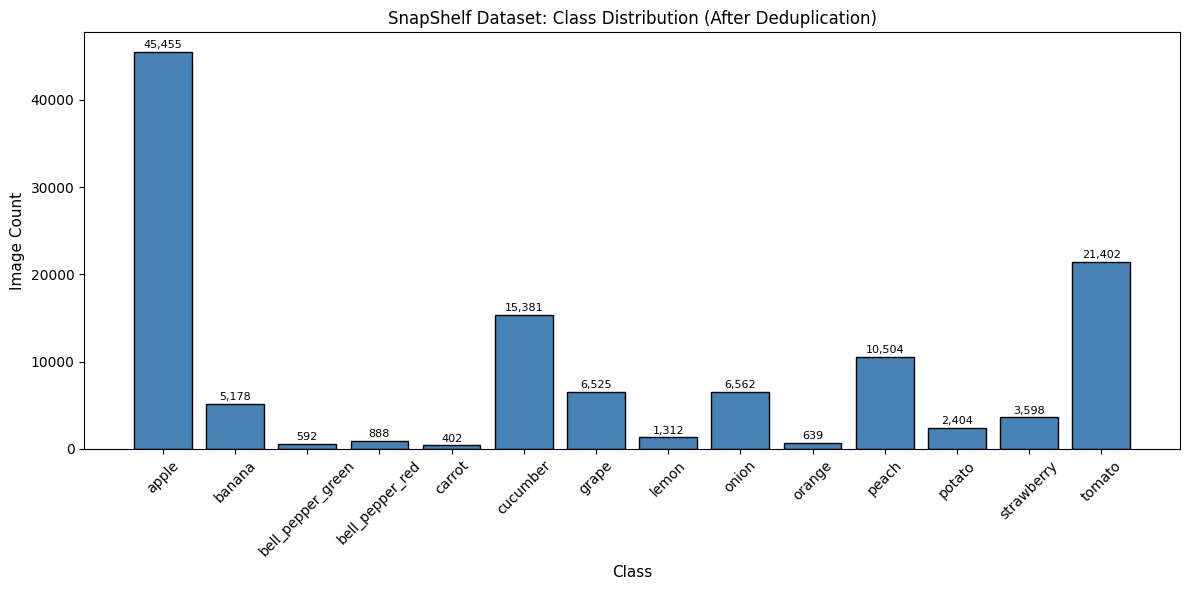


Saved: /content/drive/MyDrive/snapshelf_final_dataset/dataset_statistics.png


In [14]:
# ============================================================================
# CELL 13: DATASET VISUALISATION
# ============================================================================
# Generates bar chart showing class distribution for documentation.
# ============================================================================

print("=" * 70)
print("VISUALISATION")
print("=" * 70)

fig, ax = plt.subplots(figsize=(12, 6))

classes = sorted(TARGET_CLASSES.keys())
final_counts = [sum(source_class[cls].values()) for cls in classes]

bars = ax.bar(classes, final_counts, color='steelblue', edgecolor='black')

ax.set_xlabel('Class', fontsize=11)
ax.set_ylabel('Image Count', fontsize=11)
ax.set_title('SnapShelf Dataset: Class Distribution (After Deduplication)', fontsize=12)
ax.tick_params(axis='x', rotation=45)

for bar, count in zip(bars, final_counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 200,
            f'{count:,}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig(STATISTICS_PLOT_PATH, dpi=150, bbox_inches='tight')
plt.show()

print(f"\nSaved: {STATISTICS_PLOT_PATH}")

In [15]:
# ============================================================================
# CELL 14: HASH CACHE
# ============================================================================
# Exports SHA-256 hashes for all retained images.
# Enables reproducibility verification and future deduplication.
# ============================================================================

print("=" * 70)
print("HASH CACHE")
print("=" * 70)

cache_records = [{
    'path': img['path'],
    'sha256': img.get('sha256', ''),
    'class_name': img['class_name'],
    'source_dataset': img['source_dataset']
} for img in all_images_deduped]

pd.DataFrame(cache_records).to_csv(HASH_CACHE_PATH, index=False)
print(f"\nSaved: {HASH_CACHE_PATH}")
print(f"Records: {len(cache_records):,}")

HASH CACHE

Saved: /content/drive/MyDrive/snapshelf_final_dataset/hash_cache.csv
Records: 120,842


In [16]:
# ============================================================================
# CELL 15: CREATE ARCHIVE
# ============================================================================
# Compresses the dataset to a ZIP archive and copies to Google Drive.
# ============================================================================

print("=" * 70)
print("CREATING ARCHIVE")
print("=" * 70)

ZIP_NAME = "snapshelf_dataset_14classes_deduped.zip"
LOCAL_ZIP = f"/content/{ZIP_NAME}"
DRIVE_ZIP = f"{OUTPUT_BASE}/{ZIP_NAME}"

os.makedirs(OUTPUT_BASE, exist_ok=True)

print(f"\nCompressing...")
start = datetime.now()
with zipfile.ZipFile(LOCAL_ZIP, 'w', zipfile.ZIP_DEFLATED) as z:
    for root, _, files in os.walk(LOCAL_OUTPUT):
        for f in files:
            path = os.path.join(root, f)
            arc = os.path.relpath(path, LOCAL_OUTPUT)
            z.write(path, arc)

elapsed = (datetime.now() - start).total_seconds()
size_mb = os.path.getsize(LOCAL_ZIP) / (1024 * 1024)
print(f"  Size: {size_mb:.1f} MB")
print(f"  Time: {elapsed:.1f}s")

print(f"\nCopying to Drive...")
shutil.copy2(LOCAL_ZIP, DRIVE_ZIP)
print(f"Saved: {DRIVE_ZIP}")

manifest_df.to_csv(MANIFEST_PATH, index=False)
print(f"Saved: {MANIFEST_PATH}")

CREATING ARCHIVE

Compressing...
  Size: 2199.9 MB
  Time: 79.3s

Copying to Drive...
Saved: /content/drive/MyDrive/snapshelf_final_dataset/snapshelf_dataset_14classes_deduped.zip
Saved: /content/drive/MyDrive/snapshelf_final_dataset/dataset_manifest.csv


In [17]:
# ============================================================================
# CELL 16: FINAL SUMMARY
# ============================================================================
# Displays comprehensive summary of the dataset preparation process.
# ============================================================================

total_images = len(manifest_df)
total_train = len(manifest_df[manifest_df['split'] == 'train'])
total_val = len(manifest_df[manifest_df['split'] == 'val'])
total_test = len(manifest_df[manifest_df['split'] == 'test'])

class_final = manifest_df.groupby('class').size().to_dict()
max_cls = max(class_final.items(), key=lambda x: x[1])
min_cls = min(class_final.items(), key=lambda x: x[1])

print("=" * 70)
print("FINAL SUMMARY")
print("=" * 70)

print(f"""
DATASET OVERVIEW
----------------
Created:        {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
Classes:        {len(TARGET_CLASSES)}
Total Images:   {total_images:,}

SOURCES
-------
- Kaggle: moltean/fruits (Fruits-360)
- Kaggle: sshikamaru/fruit-recognition
- Kaggle: utkarshsaxenadn/fruits-classification

DEDUPLICATION
-------------
Method:         SHA-256 cryptographic hash
Original:       {len(all_images_raw):,}
Removed:        {removed_count:,} ({removed_count/len(all_images_raw)*100:.1f}%)
Final:          {total_images:,}

LEAKAGE CHECK
-------------
Result:         {'PASSED' if LEAKAGE_CHECK_PASSED else 'FAILED'}
Train AND Val:  {leak['train_val']}
Train AND Test: {leak['train_test']}
Val AND Test:   {leak['val_test']}

DATA SPLIT
----------
Train:          {total_train:,} ({total_train/total_images:.1%})
Validation:     {total_val:,} ({total_val/total_images:.1%})
Test:           {total_test:,} ({total_test/total_images:.1%})

CLASS IMBALANCE
---------------
Largest:        {max_cls[0]} ({max_cls[1]:,})
Smallest:       {min_cls[0]} ({min_cls[1]:,})
Ratio:          {max_cls[1]/min_cls[1]:.1f}:1
Mitigation:     Class weights exported

OUTPUT FILES
------------
{DRIVE_ZIP}
{MANIFEST_PATH}
{DEDUP_REPORT_PATH}
{EXCLUSION_AUDIT_PATH}
{CLASS_MAPPING_PATH}
{CLASS_WEIGHTS_PATH}
{STATISTICS_PLOT_PATH}
""")

print("=" * 70)
print("DATASET PREPARATION COMPLETE")
print("=" * 70)

FINAL SUMMARY

DATASET OVERVIEW
----------------
Created:        2026-01-24 17:23:26
Classes:        14
Total Images:   120,842

SOURCES
-------
- Kaggle: moltean/fruits (Fruits-360)
- Kaggle: sshikamaru/fruit-recognition
- Kaggle: utkarshsaxenadn/fruits-classification

DEDUPLICATION
-------------
Method:         SHA-256 cryptographic hash
Original:       163,316
Removed:        42,474 (26.0%)
Final:          120,842

LEAKAGE CHECK
-------------
Result:         PASSED
Train AND Val:  0
Train AND Test: 0
Val AND Test:   0

DATA SPLIT
----------
Train:          84,582 (70.0%)
Validation:     18,119 (15.0%)
Test:           18,141 (15.0%)

CLASS IMBALANCE
---------------
Largest:        apple (45,455)
Smallest:       carrot (402)
Ratio:          113.1:1
Mitigation:     Class weights exported

OUTPUT FILES
------------
/content/drive/MyDrive/snapshelf_final_dataset/snapshelf_dataset_14classes_deduped.zip
/content/drive/MyDrive/snapshelf_final_dataset/dataset_manifest.csv
/content/drive/MyDr